In [1]:
!nvidia-smi

Wed Jul 17 16:24:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:01:00.0 Off |                  Off |
| 57%   81C    P2             269W / 300W |  17344MiB / 49140MiB |     73%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Reference: https://github.com/shauli-ravfogel/nullspace_projection/blob/master/notebooks/word_vectors_debiasing.ipynb

# Visualize the debiasing effect of INLP using stereotyped professions

# Load dataset

In [5]:
# Setting up variables (formerly command-line arguments)
input_path = '/home/ongzhiyang/bias-bench-main/visualization/inlp_glove_embeddings/glove.42B.300d.txt'
output_dir = "/home/ongzhiyang/bias-bench-main/visualization/inlp_glove_embeddings/"
top_k = 150000
keep_gendered = False
keep_names = False

In [6]:
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
import numpy as np
import tqdm
import string
import codecs
import json
import sys
from typing import List, Tuple


def glove_to_word2vec(glove_filename, word2vec_output_file):
    """
    Convert GloVe file to Word2Vec format and save the result.
    :param glove_filename: Path to the GloVe file.
    :param word2vec_output_file: Path to the output Word2Vec format file.
    """
    from gensim.scripts.glove2word2vec import glove2word2vec
    glove2word2vec(glove_filename, word2vec_output_file)

def get_excluded_words():
    """
    :return: excluded words, a list of words we possibly want to remove.
             the list of excluded words is based on Gonen et at. 2019 and contains gender specific words.
    """
    with codecs.open('/home/ongzhiyang/nullspace_projection-master/data/lists/gender_specific_full.json') as f:
        gender_specific = json.load(f)

    exclude_words = list(set(gender_specific))
    return exclude_words

def get_names():
    """
    A list of gender-specific first names.
    """
    with open("/home/ongzhiyang/nullspace_projection-master/data/lists/first_names_clean.txt", "r") as f:
        lines = f.readlines()

    names = [l.strip().lower() for l in lines]
    return names

def load_model(fname, binary) -> Tuple[gensim.models.keyedvectors.KeyedVectors, List[np.ndarray], List[str]]:
    """
    :param fname: str, the filename of the embeddings file
    :param binary: whether the format is binary
    :return: a tuple model:gensim.models.keyedvectors.WordEmbeddingsKeyedVectors, vecs: list of np arrays,
            words: list of strings
    """
    model = KeyedVectors.load_word2vec_format(fname, binary=binary)
    vecs = model.vectors
    words = list(model.key_to_index.keys())

    return model, vecs, words

def has_punct(w: str):
    """
    :param w: a word
    :return: True if contains punctuation, False otherwise
    """
    if any([c in string.punctuation for c in w]):
        return True
    return False

def has_digit(w):
    """
    :param w: a word
    :return: True if contains digit, False otherwise
    """
    if any([c in '0123456789' for c in w]):
        return True
    return False

def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):
    """
    :param vecs: np array of vectors
    :param words: np array of strings
    :param fname: fname to save
    :return:
    saves the vectors in a word2vec format
    """
    with open(fname, "w") as f:
        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v, w) in tqdm.tqdm(enumerate(zip(vecs, words))):
            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")

def filter_vecs(vecs: np.ndarray, words: np.ndarray, keep_gendered: bool, keep_names: bool):
    """
    :param vecs: the complete set of pretrained vectors
    :param words: the corresponding words
    :param keep_gendered: whether or not to keep inherently gendered words
    :param keep_names:  whether or not to keep names
    :return: two tuples, one contains the filtered vecs and words, the other only the gendered ones
    """
    filtered = []
    gendered_words = []

    excluded_words = get_excluded_words()
    first_names = set(get_names())

    for i, (v, w) in tqdm.tqdm(enumerate(zip(vecs, words))):
        if (w in first_names) and not keep_names:
            continue

        if w in excluded_words:
            gendered_words.append((w, v))
            if not keep_gendered:
                continue

        if len(w) >= 20:
            continue
        if has_digit(w):
            continue
        if '_' in w:
            p = [has_punct(subw) for subw in w.split('_')]
            if not any(p):
                filtered.append((w, v))
            continue
        if has_punct(w):
            continue

        filtered.append((w, v))

    words, vecs = zip(*filtered)
    vecs = np.array(vecs)
    words = list(words)

    words_gendered, vecs_gendered = zip(*gendered_words)
    vecs_gendered = np.array(vecs_gendered)
    words_gendered = list(words_gendered)

    return (vecs, words), (words_gendered, vecs_gendered)

def save_voc(voc: List[str], path: str):
    """
    :param voc: list of words in the vocab
    :param path: path to save
    :return:
    """
    with open(path, "w", encoding="utf-8") as f:
        for w in voc:
            f.write(w + "\n")

# Main execution

# Convert GloVe to Word2Vec format
word2vec_file = output_dir + "word2vec.txt"
glove_to_word2vec(input_path, word2vec_file)

# Load the model
model, vecs, words = load_model(word2vec_file, binary=False)

# Filter vectors
(vecs, words), (words_gendered, vecs_gendered) = filter_vecs(vecs, words, keep_gendered, keep_names)

# Save filtered vectors
save_in_word2vec_format(vecs[:top_k], words, output_dir + "vecs.filtered.txt")

# Save gendered vectors
save_in_word2vec_format(vecs_gendered, words_gendered, output_dir + "vecs.gendered.txt")

# Save vocabulary
save_voc(words[:top_k], output_dir + "voc.txt")

print("Processing complete. Files saved in the output directory.")

/home/ongzhiyang/anaconda3/envs/fyp/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_3812513/3355538505.py:20: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_filename, word2vec_output_file)
1917494it [00:33, 57173.22it/s]
150000it [00:19, 7771.59it/s]
455it [00:00, 7774.16it/s]


Processing complete. Files saved in the output directory.


# Visualize

In [3]:
import sys
sys.path.append("inlp_glove_embeddings")
import debias
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
import numpy as np
import random
import sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000
from sklearn.utils import shuffle

#import warnings
#warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload

/home/ongzhiyang/anaconda3/envs/fyp/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data loading & processing

In [4]:
# def load_word_vectors(fname):
#
#     model = KeyedVectors.load_word2vec_format(fname, binary=False)
#     vecs = model.vectors
#     words = list(model.vocab.keys())
#     return model, vecs, words
from gensim.models import KeyedVectors

def load_word_vectors(fname):
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = model.index_to_key
    return model, vecs, words

def project_on_gender_subspaces(gender_vector, model: Word2VecKeyedVectors, n = 2500):
    
    group1 = model.similar_by_vector(gender_vector, topn = n, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = n, restrict_vocab=None)
    
    all_sims = model.similar_by_vector(gender_vector, topn = len(model.vectors), restrict_vocab=None)
    eps = 0.03
    idx = [i for i in range(len(all_sims)) if abs(all_sims[i][1]) < eps]
    samp = set(np.random.choice(idx, size = n))
    neut = [s for i,s in enumerate(all_sims) if i in samp]
    return group1, group2, neut

def get_vectors(word_list: list, model: Word2VecKeyedVectors):
    
    vecs = []
    for w in word_list:
        
        vecs.append(model[w])
    
    vecs = np.array(vecs)

    return vecs
    
def get_bias_by_neighbors(model, v, gender_direction, topn): 
    
    neighbors = model.similar_by_vector(v, topn = topn) 
    neighbors_words = [n for n, _ in neighbors]
    
    #bias = len([n for n in neighbors_words if n in gendered_words])
    bias = len([n for n in neighbors_words if model.cosine_similarities(model[n], [gender_direction])[0] > 0])
    bias /= (1.*topn)
    return bias


def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v,w) in tqdm.tqdm_notebook(enumerate(zip(vecs, words))):

            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")

### Load word vectors

In [13]:
# 150k top vectors (with gender-typical words) - used for training

model, vecs, words = load_word_vectors(fname = "inlp_glove_embeddings/vecs.filtered.txt")

# only gendered vectors

model_gendered, _, _ = load_word_vectors(fname = "inlp_glove_embeddings/vecs.gendered.txt")


### Collect biased words

In [15]:
num_vectors_per_class = 7500

by_pca = False
if by_pca:
    pairs = [("male", "female"), ("masculine", "feminine"), ("he", "she"), ("him", "her")]
    gender_vecs = [model[p[0]] - model[p[1]] for p in pairs]
    pca = PCA(n_components=1)
    pca.fit(gender_vecs)
    gender_direction = pca.components_[0]

else:
    gender_direction = model["he"]-model["she"] 


gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
masc_words_and_scores, fem_words_and_scores, neut_words_and_scores = project_on_gender_subspaces(gender_direction, model, n = num_vectors_per_class)

masc_words, masc_scores = list(zip(*masc_words_and_scores))
neut_words, neut_scores = list(zip(*neut_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))
masc_vecs, fem_vecs = get_vectors(masc_words, model), get_vectors(fem_words, model)
neut_vecs = get_vectors(neut_words, model)

# n = min(3000, num_vectors_per_class)
# all_significantly_biased_words = masc_words[:n] + fem_words[:n]
# all_significantly_biased_vecs =  np.concatenate((masc_vecs[:n], fem_vecs[:n]))
# all_significantly_biased_labels = np.concatenate((np.ones(n, dtype = int),
#                                                   np.zeros(n, dtype = int)))
# 
# all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(
# all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)
# #print(np.random.choice(masc_words, size = 75))
# print("TOP MASC")
# print(masc_words[:50])
# #print("LAST MASC")
# #print(masc_words[-120:])
# print("-------------------------")
# #print(np.random.choice(fem_words, size = 75))
# print("TOP FEM")
# print(fem_words[:50])
# #print("LAST FEM")
# #print(fem_words[-120:])
# print("-------------------------")
# #print(np.random.choice(neut_words, size = 75))
# print(neut_words[:50])


### Perform train-dev-test split

In [16]:
random.seed(0)
np.random.seed(0)

X = np.concatenate((masc_vecs, fem_vecs, neut_vecs), axis = 0)
#X = (X - np.mean(X, axis = 0, keepdims = True)) / np.std(X, axis = 0)
y_masc = np.ones(masc_vecs.shape[0], dtype = int)
y_fem = np.zeros(fem_vecs.shape[0], dtype = int)
y_neut = -np.ones(neut_vecs.shape[0], dtype = int)
#y = np.concatenate((masc_scores, fem_scores, neut_scores))#np.concatenate((y_masc, y_fem))
y = np.concatenate((y_masc, y_fem, y_neut))
X_train_dev, X_test, y_train_dev, Y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 10772; Dev size: 4617; Test size: 6596


### Debias

In [17]:
gender_clf = LinearSVC
#gender_clf = SGDClassifier
#gender_clf = LogisticRegression
#gender_clf = LinearDiscriminantAnalysis
#gender_clf = Perceptron

params_svc = {'fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
params_sgd = {'fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
params = params_svc
#params = {'loss': 'hinge', 'n_jobs': 16, 'penalty': 'l2', 'max_iter': 2500, 'random_state': 0}
#params = {}
n = 35
min_acc = 0
is_autoregressive = True
dropout_rate = 0

P, rowspace_projs, Ws = debias.get_debiasing_projection(gender_clf, params, n, 300, is_autoregressive, min_acc,
                                    X_train, Y_train, X_dev, Y_dev,
                                       Y_train_main=None, Y_dev_main=None, 
                                        by_class = False, dropout_rate = dropout_rate)

iteration: 34, accuracy: 0.3387481048299762: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [03:43<00:00,  6.40s/it]


### Save debiased vectors

In [18]:
vecs_cleaned = (P.dot(vecs.T)).T
save_in_word2vec_format(vecs_cleaned, words, "inlp_glove_embeddings/vecs.150k.cleaned.txt")
model_cleaned, _, _ = load_word_vectors(fname = "inlp_glove_embeddings/vecs.150k.cleaned.txt")

/tmp/ipykernel_3946304/2638450239.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (v,w) in tqdm.tqdm_notebook(enumerate(zip(vecs, words))):


0it [00:00, ?it/s]

#### Plot distance of biased profession word vectors

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def plot_profession_pronoun_distances(model, model_cleaned, P, professions, male_dominated, female_dominated, output_dir='.'):
    # Calculate distances
    him_vec, her_vec = model['he'], model['she']
    him_vec_cleaned, her_vec_cleaned = model_cleaned['he'], model_cleaned['she']

    distances_him_before, distances_her_before = [], []
    distances_him_after, distances_her_after = [], []
    valid_professions = []

    for profession in professions:
        if profession not in model:
            print(f"Warning: '{profession}' not found in the model. Skipping.")
            continue

        prof_vec = model[profession]
        prof_vec_cleaned = np.dot(P, prof_vec)

        distances_him_before.append(np.linalg.norm(prof_vec - him_vec))
        distances_her_before.append(np.linalg.norm(prof_vec - her_vec))
        distances_him_after.append(np.linalg.norm(prof_vec_cleaned - him_vec_cleaned))
        distances_her_after.append(np.linalg.norm(prof_vec_cleaned - her_vec_cleaned))
        valid_professions.append(profession)

    # Create two separate plots
    for distances_him, distances_her, title in [
        (distances_him_before, distances_her_before, "Before Debiasing"),
        (distances_him_after, distances_her_after, "After Debiasing")
    ]:
        fig, ax = plt.subplots(figsize=(10, 8))
        
        for i, profession in enumerate(valid_professions):
            color = 'blue' if profession in male_dominated else 'red' if profession in female_dominated else 'gray'
            ax.scatter(distances_him[i], distances_her[i], alpha=0.7, color=color)
            ax.annotate(profession, (distances_him[i], distances_her[i]), fontsize=8)

        ax.set_xlabel("Distance to 'him' vector")
        ax.set_ylabel("Distance to 'her' vector")
        ax.set_title(f"Profession-Pronoun Distances: {title}")
        
        # Plot diagonal line
        min_val = min(ax.get_xlim()[0], ax.get_ylim()[0])
        max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)
        
        # Set equal aspect ratio
        ax.set_aspect('equal', adjustable='box')

        # Add correlation to plot
        corr, _ = pearsonr(distances_him, distances_her)
        ax.text(0.05, 0.95, f'Correlation: {corr:.4f}', transform=ax.transAxes, 
                verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

        # Add legend
        custom_lines = [plt.Line2D([0], [0], color='blue', lw=4),
                        plt.Line2D([0], [0], color='red', lw=4),
                        plt.Line2D([0], [0], color='gray', lw=4)]
        ax.legend(custom_lines, ['Male-dominated', 'Female-dominated', 'Neutral'], 
                  loc='lower right')

        plt.tight_layout()
        
        # Save the figure
        filename = f'profession_pronoun_distances_{title.lower().replace(" ", "_")}.png'
        filepath = f'{output_dir}/{filename}'
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        # Show
        plt.show()
        print(f"Saved chart: {filepath}")

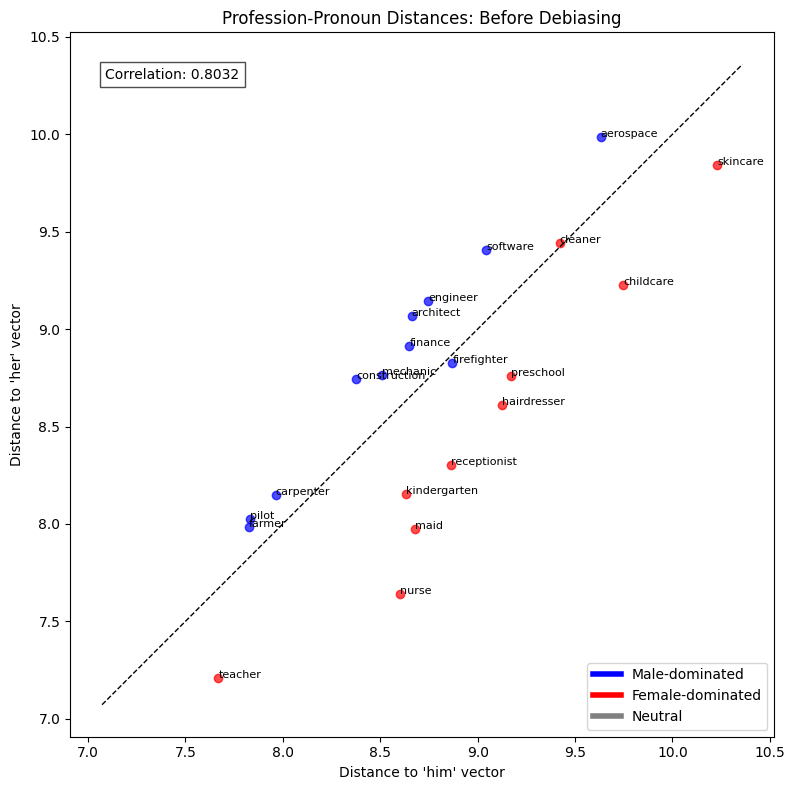

Saved chart: media/inlp/profession_pronoun_distances_before_debiasing.png


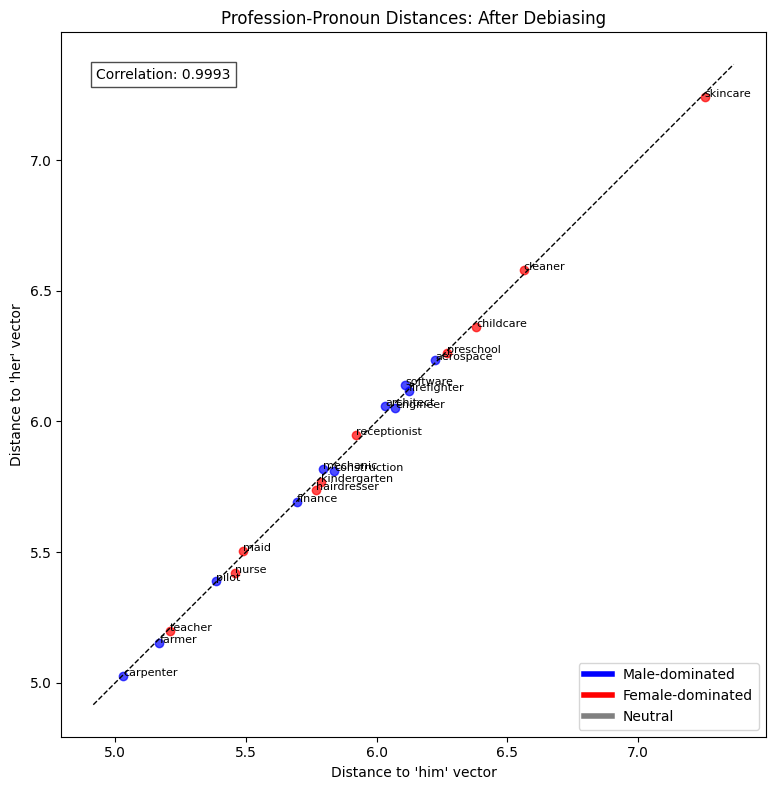

Saved chart: media/inlp/profession_pronoun_distances_after_debiasing.png


In [43]:
male_dominated = {'mechanic', 'software', 'farmer', 'construction', 'finance', 'aerospace', 'architect', 'pilot', 'engineer', 'firefighter', 'carpenter'}
female_dominated = {'preschool', 'kindergarten', 'childcare', 'skincare', 'receptionist', 'hairdresser', 'nurse', 'teacher', 'maid', 'cleaner'}
custom_professions = list(male_dominated | female_dominated)

plot_profession_pronoun_distances(model, model_cleaned, P, custom_professions, male_dominated, female_dominated, output_dir='media/inlp')

# Summary of code

## 1. Data Preparation
- Converts GloVe embeddings to Word2Vec format for easier processing.
- Filters the vocabulary, optionally keeping or removing gendered words and names.
- Saves the filtered embeddings and vocabulary.

## 2. Loading and Processing
- Loads the filtered word vectors and gendered vectors.
- Identifies gender-biased words by projecting words onto a gender direction (defined by the difference between "he" and "she" embeddings).
- Separates words into masculine, feminine, and neutral categories based on their projection onto the gender direction.

## 3. Train-Dev-Test Split
- Splits the data into training, development, and test sets for the debiasing process.

## 4. Debiasing
- Uses the Iterative Nullspace Projection (INLP) method to debias the word embeddings.
- Trains a series of linear classifiers (SVC) to identify and remove gender direction from the embeddings.

## 5. Saving Debiased Vectors
- Applies the learned projection to the original vectors to create debiased embeddings.
- Saves the debiased embeddings in Word2Vec format.

## 6. Visualization
- Includes a function to plot the distances of profession word vectors to gendered pronouns ("he" and "she") before and after debiasing.
- Calculates and displays the correlation between these distances to show the effect of debiasing.